# Step 1: preprocessing

In [3]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

# 1. Download historical closing price data for Ethereum (ETH-USD)
print('Downloading ETH-USD data...')
df = yf.download(tickers='ETH-USD', start='2018-01-01')

df.to_excel('ds/eth_data.xlsx')

/var/folders/ht/70hjrhkx4j305ctfw65z_43h0000gn/T/ipykernel_53449/4259983656.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers='ETH-USD', start='2018-01-01')
[*********************100%***********************]  1 of 1 completed


In [4]:
# 2. Select only the 'Close' column
data = df[['Close']].values

# 3. Normalize data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 4. Function to transform time series into a dataset for LSTM
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

look_back = 60  # Number of previous days used to predict the next
dataX, dataY = create_dataset(data_scaled, look_back)

In [5]:
# 5. Split into training (80%) and testing (20%) sets
train_size = int(len(dataX) * 0.8)
X_train, X_test = dataX[:train_size], dataX[train_size:]
y_train, y_test = dataY[:train_size], dataY[train_size:]

# 6. Reshape the data to [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Step 2: Training

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Build a simple LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 2. Train the model
print('Training the model...')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

2025-06-22 10:32:34.469121: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-06-22 10:32:34.469170: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-22 10:32:34.469175: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1750599154.469662 76770505 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1750599154.469730 76770505 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.1/projects/workspace/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models,

Training the model...
Epoch 1/10


2025-06-22 10:32:35.005061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0311 - val_loss: 3.4070e-04
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0014 - val_loss: 3.5358e-04
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0013 - val_loss: 4.3756e-04
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0013 - val_loss: 2.5764e-04
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0014 - val_loss: 2.7175e-04
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 8.8257e-04 - val_loss: 2.3743e-04
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 8.5204e-04 - val_loss: 3.2877e-04
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 9.1463e-04 - val_loss: 1.9792e-04
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.1906e-04 - val_loss: 8.6373e-04
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 8.8210e-04 - val_loss: 2.1599e-04


# Step 3: Evaluate model

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# 3. Make predictions on the test set
print('Making predictions...')
predictions = model.predict(X_test)

# 4. Invert the normalization to get original values
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# 5. Model evaluation
mse = mean_squared_error(y_test_inv, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, predictions)
mape = np.mean(np.abs((y_test_inv - predictions) / y_test_inv)) * 100

print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')  # How many dollars in average the model has errors
print(f'MAE: {mae:.2f}')  #
print(f'MAPE: {mape:.2f}%')  # % of error

Making predictions...
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


KeyboardInterrupt: 

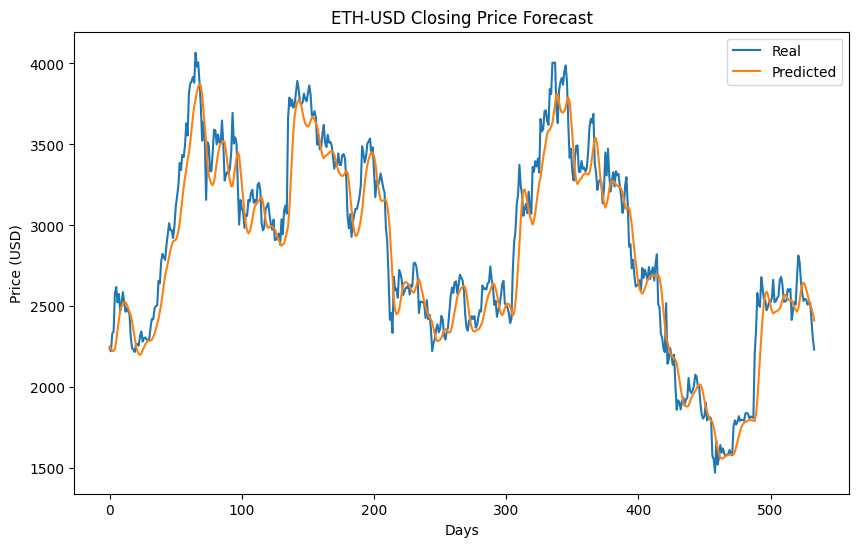

Model saved successfully


In [10]:
# 6. Plot of real vs predicted results
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Real')
plt.plot(predictions, label='Predicted')
plt.title('ETH-USD Closing Price Forecast')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# 7. Save the trained model and scaler (artifacts)
model.save('modelo_eth_lstm.keras')
print('Model saved successfully')

# Step 4: Use model

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Forecast the next x days
days = 60
last_sequence = data_scaled[-look_back:].reshape(1, look_back, 1)
next_predictions = []

for _ in range(days):
    next_value = model.predict(last_sequence)[0][0]
    next_predictions.append(next_value)
    last_sequence = np.append(last_sequence[:, 1:, :], [[[next_value]]], axis=1)

# 2. Invert normalization
next_predictions_real = scaler.inverse_transform(np.array(next_predictions).reshape(-1, 1))
print('Next 60 closing price forecasts for ETH (USD):')
print(next_predictions_real.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

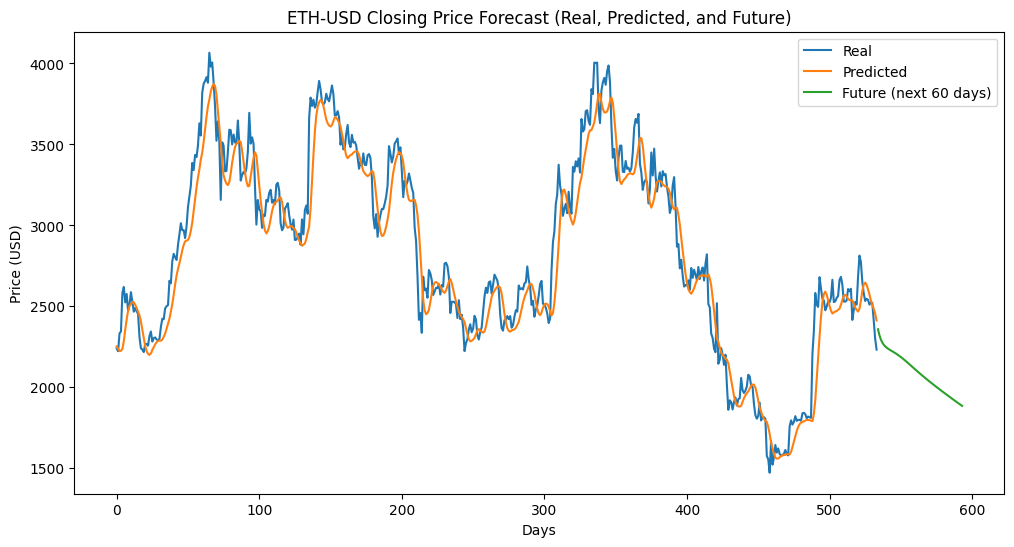

In [15]:
# 3. New plot with future forecasts
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test_inv)), y_test_inv, label='Real')
plt.plot(np.arange(len(predictions)), predictions, label='Predicted')
plt.plot(np.arange(len(y_test_inv), len(y_test_inv) + days), next_predictions_real, label=f'Future (next {days} days)')

plt.title('ETH-USD Closing Price Forecast (Real, Predicted, and Future)')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()